# Teste supervisionado com dados tunados

In [ ]:
#import os pacotes utilizados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

#selecionando atributos 
from sklearn.feature_selection import RFECV

#resample
from sklearn.utils import resample

#ESCALONAMENTO DE DADOS
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler

#SELECIONANDO MELHOR MODELO
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from scipy.stats import randint as sp_randint
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score

#Evaluating
import seaborn as sns; sns.set()

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import f1_score

#EXPORTAR ARVORE
from sklearn.tree import export_graphviz
import os

#CURVA ROC
%matplotlib inline
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import roc_auc_score

#REDUÇÃO DE DIMENSIONALIDADE
from sklearn.decomposition import PCA

#exibindo todas as colunas
pd.set_option('display.max_columns', None)

#definicao de funcoes que serao utilizadas
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
def plot_roc_curve(fpr, tpr, label=None):    
    plt.plot(fpr, tpr, linewidth=2, label=label)    
    plt.plot([0, 1], [0, 1], 'k--')    
    plt.axis([0, 1, 0, 1])   
    plt.xlabel('False Positive Rate')    
    plt.ylabel('True Positive Rate')
    
#definindo score
from sklearn.metrics import make_scorer
from sklearn.metrics import cohen_kappa_score

def score_evasao(y_true, y_pred): 
    tp = confusion_matrix(y_true, y_pred)[0, 0]
    fn = confusion_matrix(y_true, y_pred)[0, 1]
    
    return tp/(tp+fn)
   
#SELECIONANDO MELHOR MODEL RF
def make_RF(Xtrain, ytrain):
    #cria a randomforest 
    #forest_clf = RandomForestClassifier(oob_score=True, n_jobs=-1) 
    forest_clf = RandomForestClassifier(n_jobs=-1) 

    param_grid_forest = {'max_depth': [3, 5, None],
                  'max_features': ['auto', 'sqrt', 'log2'],
                  'n_estimators': [10, 30, 60, 100, 200],
                  'criterion': ["gini", "entropy"], 
                   #'class_weight': [{0:10, 1:.1}, 'balanced'] #foi utilizado quando os dados estavam desbalanceados
                    }

    
    #utilizando o score definido de acordo com a evasao
    #print(score_evasao(ytest, ypred_forest))
    #se = make_scorer(score_evasao)

    #seleciona o melhor modelo de acordo com os parâmetros
    #grid_search_forest = GridSearchCV(estimator=forest_clf, param_grid=param_grid_forest, cv=10)    
    #grid_search_forest = GridSearchCV(estimator=forest_clf, param_grid=param_grid_forest, scoring = 'f1')
    #grid_search_forest = GridSearchCV(estimator=forest_clf, param_grid=param_grid_forest, scoring = 'roc_auc')
    
    kappa_scorer = make_scorer(cohen_kappa_score)
    grid_search_forest = GridSearchCV(estimator=forest_clf, param_grid=param_grid_forest, scoring = kappa_scorer, cv=10)
    
    grid_search_forest.fit(Xtrain, ytrain)
    print(grid_search_forest.best_params_)
    print(grid_search_forest.best_estimator_)
    
    #mostra os 5 melhores modelos
    report(grid_search_forest.cv_results_, 5)    
    
    return grid_search_forest.best_estimator_

def evaluating(model, ytest, ypred, Xtest):
    #Evaluating
    mat = confusion_matrix(ytest, ypred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    
    s = mat[0][1]/(mat[0][0]+mat[0][1])
    print("Valor de falso positivo:"+str(s))
    
    #evaluating
    print("Cálculo de índices de avaliação:")
    
    print("Precisão: %f; Recall: %f, F1: %f" % (precision_score(ytest, ypred), 
                                                recall_score(ytest, ypred), 
                                                f1_score(ytest, ypred) ))

    #precisao
    print('Precisão CV:')
    scores = cross_val_score(model, Xtest, ytest, cv=10)
    accuracy = np.mean(scores)
    print(scores)
    print(accuracy)

    #CURVA ROC
    fig = plt.figure()
    y_probas = cross_val_predict(model, Xtest, ytest, cv=10, method="predict_proba") 

    y_scores = y_probas[:, 1]   # score = proba of positive class 
    fpr, tpr, thresholds = roc_curve(ytest, y_scores)

    plot_roc_curve(fpr, tpr) 
    plt.show()
    print(roc_auc_score(ytest, y_scores))
    
def feature_ranking(Xtest, model):
    #exibe os atributos mais importantes
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(Xtest.shape[1]):
        print("%d. feature %d [%s] (%f)" % (f + 1, indices[f], Xtest.columns[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(Xtest.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(Xtest.shape[1]), indices)
    plt.xlim([-1, Xtest.shape[1]])
    plt.show()    
    
def evaluating_2(model, ytest, ypred, X, y, Xtest):
    #Evaluating
    plt.figure()
    mat = confusion_matrix(ytest, ypred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    
    s = mat[0][1]/(mat[0][0]+mat[0][1])
    print("Valor de falso positivo:"+str(s))
    
    #evaluating
    print(precision_score(ytest, ypred))
    print(recall_score(ytest, ypred))

    #evaluating
    print(precision_score(ytest, ypred))
    print(recall_score(ytest, ypred))
    print(f1_score(ytest, ypred))

    #precisao
    print('Precisao')
    scores = cross_val_score(model, X, y, cv=10)
    accuracy = np.mean(scores)
    print(scores)
    print(accuracy)

#limpando os NaN devido ao RF
def preparing_data(dados):
    print(dados.shape)
    dados = dados.dropna()
    print(dados.shape)
    
    #configura os dados de entrada e saída
    y = dados.classe
    X = dados

    del X['classe']
    X.shape    
    
    #binazira os dados devido aos atributos categoricos 
    dados_dummies = pd.get_dummies(X, drop_first=True)
    dados_dummies.shape

    #remove atributos inconistentes
    dados_clean = dados_dummies.replace([np.inf, -np.inf], np.nan)
    dados_clean = dados_clean.dropna(axis=1, how='all')
    print(dados_clean.info())
    
    return (dados_clean, y)

In [23]:
dados_tunning = pd.read_json('dados/dados_workflow_ivan.json')
dados = dados_tunning.copy()
dados.head(2)

,LnguaPortuguesaeLiteraturaI90H,LnguaPortuguesaeLiteraturaI90H_dependencia,LnguaPortuguesaeLiteraturaI90H_freq,MatemticaI120H,MatemticaI120H_dependencia,MatemticaI120H_freq,acompanhamento,aluno_exclusivo_rede_publica,artificial,classe,conceito,conceito_freq,descricao,descricao_area_residencial,descricao_companhia_domiciliar,descricao_estado_civil,descricao_historico,descricao_imovel,descricao_mae_escolaridade,descricao_pai_escolaridade,descricao_raca,descricao_responsavel_escolaridade,descricao_responsavel_financeiro,descricao_trabalho,id,idade,pessoa_fisica__sexo,possui_necessidade_especial,qnt_pc,qnt_salarios,qtd_pessoas_domicilio,sigla,tempo_entre_conclusao_ingresso
0,68.0,0,100.0,66.0,0,100.0,0,False,0,1,B,A,Matriculado,Urbana,Mãe,Solteiro(a),Técnico de Nivel Médio em Informática,Alugado,Ensino fundamental incompleto,Ensino fundamental incompleto,Branca,Ensino fundamental incompleto,Mãe,Não informado,457884597605,15,F,False,0,1,2,LAJ,1
1,73.0,1,100.0,36.0,1,91.0,0,False,1,0,R,R,Cancelado,Urbana,Mãe,Solteiro(a),Técnico de Nível Médio em Meio Ambiente,Alugado,Ensino fundamental incompleto,Ensino fundamental incompleto,Parda,Ensino fundamental incompleto,Mãe,Não informado,458436647741,17,M,False,1,1,2,SPP,2


# Modelo 01: utilizando todos os dados

no cenário abaixo foram utilizados todos os dados incluindo as notas as quais os valores NAN foram preenchidas com -1, a fim de não serem limpados. 

o resultado como visto foi bastante instatisfatório, uma vez que o falto positivo (prever que não evadiu, mas o aluno evadiu) tem um valor muito elevado, sendo o pior erro no problema. É interessante notar que os índices de avaliação tradicionais (precision, recall, f1) foram bons, o que parece contraditório. A explicação se deve ao fato das classes estarem bastante desbalanceadas. Para a seleção do modelo foi utilizado o médodo kappa_scorer o que conseguiu trazer a tona o problema do erro elevado de falso positivo  

In [32]:
dados = dados_tunning.copy()

dados = dados[[
       'LnguaPortuguesaeLiteraturaI90H',
       'LnguaPortuguesaeLiteraturaI90H_dependencia',
       'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H',
       'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento',
       'aluno_exclusivo_rede_publica', 'artificial', 'classe', 'conceito',
       'conceito_freq', 'descricao_area_residencial',
       'descricao_companhia_domiciliar', 'descricao_estado_civil',
       'descricao_historico', 'descricao_imovel', 'descricao_mae_escolaridade',
       'descricao_pai_escolaridade', 'descricao_raca',
       'descricao_responsavel_escolaridade',
       'descricao_responsavel_financeiro', 'descricao_trabalho', 'idade',
       'pessoa_fisica__sexo', 'possui_necessidade_especial', 'qnt_pc',
       'qnt_salarios', 'qtd_pessoas_domicilio', 'sigla',
       'tempo_entre_conclusao_ingresso'    
]]

#convertendo os NaN das notas em -1 para usar o RF 
dados['LnguaPortuguesaeLiteraturaI90H'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaI90H_dependencia'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaI90H_freq'].fillna(-1, inplace=True)

dados['MatemticaI120H'].fillna(-1, inplace=True)
dados['MatemticaI120H_dependencia'].fillna(-1, inplace=True)
dados['MatemticaI120H_freq'].fillna(-1, inplace=True)

(8908, 31)
(8908, 31)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8908 entries, 0 to 998
Columns: 151 entries, LnguaPortuguesaeLiteraturaI90H to sigla_ZN
dtypes: bool(2), float64(4), int64(9), uint8(136)
memory usage: 2.1 MB
None


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


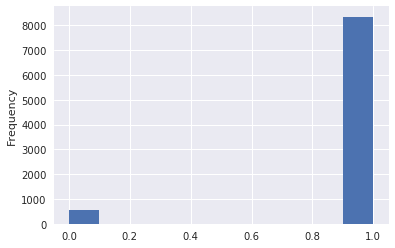

In [33]:
X, y = preparing_data(dados)
y.plot.hist()

In [34]:
#dividir os dados para treino e teste. default é 25% p teste
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0, stratify = y)

In [35]:
#seleciona o melhor modelo
model_forest_completo = make_RF(Xtrain, ytrain)
ypred_forest = model_forest_completo.predict(Xtest)

{'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 60}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Model with rank: 1
Mean validation score: 0.583 (std: 0.059)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 60}

Model with rank: 2
Mean validation score: 0.582 (std: 0.062)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}

Model with rank: 3
Mean validation score: 0.581 (std: 0.064)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 30}

Model with r

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Valor de falso positivo:0.5683453237410072
Cálculo de índices de avaliação:
Precisão: 0.963290; Recall: 0.992816, F1: 0.977830
Precisão CV:
[0.95403587 0.96188341 0.95286195 0.95959596 0.96632997 0.95510662
 0.96516854 0.96179775 0.95280899 0.96516854]
0.9594757603297097


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


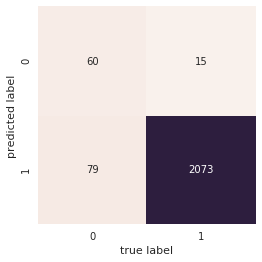

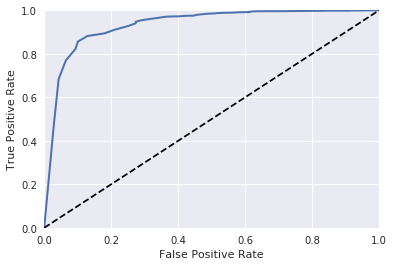

0.9331741503349047
Feature ranking:
1. feature 0 [LnguaPortuguesaeLiteraturaI90H] (0.082467)
2. feature 3 [MatemticaI120H] (0.075407)
3. feature 15 [conceito_I] (0.069730)
4. feature 5 [MatemticaI120H_freq] (0.049931)
5. feature 17 [conceito_R] (0.046689)
6. feature 2 [LnguaPortuguesaeLiteraturaI90H_freq] (0.040422)
7. feature 9 [idade] (0.031313)
8. feature 33 [descricao_estado_civil_Divorciado(a)] (0.025804)
9. feature 13 [qtd_pessoas_domicilio] (0.022083)
10. feature 20 [conceito_freq_R] (0.020824)
11. feature 1 [LnguaPortuguesaeLiteraturaI90H_dependencia] (0.017410)
12. feature 12 [qnt_salarios] (0.016584)
13. feature 14 [tempo_entre_conclusao_ingresso] (0.015419)
14. feature 4 [MatemticaI120H_dependencia] (0.015352)
15. feature 141 [sigla_MC] (0.015244)
16. feature 6 [acompanhamento] (0.015219)
17. feature 19 [conceito_freq_I] (0.015023)
18. feature 11 [qnt_pc] (0.013176)
19. feature 23 [descricao_area_residencial_Não informado] (0.012089)
20. feature 126 [descricao_trabalho_Não i

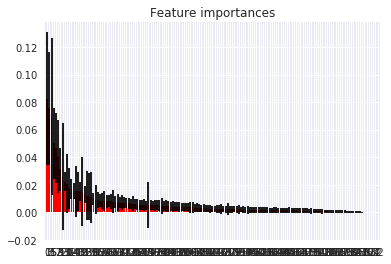

In [36]:
#avaliacao do modelo
evaluating(model_forest_completo, ytest, ypred_forest, Xtest)

feature_ranking(Xtest, model_forest_completo)

# Modelo 02: aumentando a quantidade de instâncias da classe de evasão

para tentar resolver o problema da classe desbalanceada será acrescentada novas instâncias a base da classe 0, a partir da duplicação de instâncias já contidas na base. Foram removidos as instâncias com dados gerados de forma artificial e as instâncias com notas NAN 

In [47]:
dados = dados_tunning.copy()

dados = dados[[
       'LnguaPortuguesaeLiteraturaI90H',
       'LnguaPortuguesaeLiteraturaI90H_dependencia',
       'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H',
       'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento',
       'aluno_exclusivo_rede_publica', 'artificial', 'classe', 'conceito',
       'conceito_freq', 'descricao_area_residencial',
       'descricao_companhia_domiciliar', 'descricao_estado_civil',
       'descricao_historico', 'descricao_imovel', 'descricao_mae_escolaridade',
       'descricao_pai_escolaridade', 'descricao_raca',
       'descricao_responsavel_escolaridade',
       'descricao_responsavel_financeiro', 'descricao_trabalho', 'idade',
       'pessoa_fisica__sexo', 'possui_necessidade_especial', 'qnt_pc',
       'qnt_salarios', 'qtd_pessoas_domicilio', 'sigla',
       'tempo_entre_conclusao_ingresso'    
]]

dados = dados[dados.artificial == 0]
dados.classe.value_counts()

1    7369
0     349
Name: classe, dtype: int64

In [48]:
Xtrain, Xtest, ytrain, ytest = train_test_split(dados, dados.classe, random_state=0, stratify = dados.classe)

In [49]:
# separa as classes majoritária e minoritária 
df_majority = Xtrain[Xtrain.classe==1]
df_minority = Xtrain[Xtrain.classe==0]
 
# Upsample classe minoritária
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample com reposição
                                 n_samples=df_majority.shape[0],    # iguala a quantidade da classe majoritária
                                 random_state=0) 
 
# junta as duas classes
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
print(df_upsampled.classe.value_counts())
dados = df_upsampled

1    5526
0    5526
Name: classe, dtype: int64


In [50]:
Xtrain, ytrain = preparing_data(dados)

Xtest, ytest = preparing_data(Xtest)
#dividir os dados para treino e teste. default é 25% p teste
#Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0, stratify = y)

(11052, 31)
(9585, 31)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9585 entries, 5781 to 6589
Columns: 149 entries, LnguaPortuguesaeLiteraturaI90H to sigla_ZN
dtypes: bool(2), float64(4), int64(9), uint8(134)
memory usage: 2.3 MB
None
(1930, 31)
(1497, 31)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1497 entries, 7727 to 5596
Columns: 145 entries, LnguaPortuguesaeLiteraturaI90H to sigla_ZN
dtypes: bool(2), float64(4), int64(9), uint8(130)
memory usage: 356.7 KB
None


In [51]:
#seleciona o melhor modelo
model_forest_up = make_RF(Xtrain, ytrain)
ypred_forest = model_forest_up.predict(Xtest)

{'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 200}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Model with rank: 1
Mean validation score: 0.993 (std: 0.003)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 200}

Model with rank: 2
Mean validation score: 0.992 (std: 0.004)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 100}

Model with rank: 3
Mean validation score: 0.992 (std: 0.005)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 200}

Model wi

ValueError: Number of features of the model must match the input. Model n_features is 149 and input n_features is 145 

In [ ]:
#avaliacao do modelo
evaluating(model_forest_up, ytest, ypred_forest, Xtest)

feature_ranking(Xtest, model_forest_up)

# Modelo 03: diminuindo a quantidade de instâncias da classe 01

In [16]:
dados = dados_tunning.copy()

dados = dados[[
       'LnguaPortuguesaeLiteraturaI90H',
       'LnguaPortuguesaeLiteraturaI90H_dependencia',
       'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H',
       'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento',
       'aluno_exclusivo_rede_publica', 'artificial', 'classe', 'conceito',
       'conceito_freq', 'descricao_area_residencial',
       'descricao_companhia_domiciliar', 'descricao_estado_civil',
       'descricao_historico', 'descricao_imovel', 'descricao_mae_escolaridade',
       'descricao_pai_escolaridade', 'descricao_raca',
       'descricao_responsavel_escolaridade',
       'descricao_responsavel_financeiro', 'descricao_trabalho', 'idade',
       'pessoa_fisica__sexo', 'possui_necessidade_especial', 'qnt_pc',
       'qnt_salarios', 'qtd_pessoas_domicilio', 'sigla',
       'tempo_entre_conclusao_ingresso'    
]] 

dados = dados[dados.artificial == 0]
print(dados.classe.value_counts())

# Separate majority and minority classes
df_majority = dados[dados.classe==1]
df_minority = dados[dados.classe==0]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=df_minority.shape[0],     # to match minority class
                                 random_state=0) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority, df_majority_downsampled])
 
# Display new class counts
df_upsampled.classe.value_counts()
dados = df_upsampled

1    7369
0     349
Name: classe, dtype: int64


In [17]:
X, y = preparing_data(dados)

#dividir os dados para treino e teste. default é 25% p teste
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0, stratify = y)

(698, 31)
(613, 31)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 613 entries, 1028 to 31
Columns: 143 entries, LnguaPortuguesaeLiteraturaI90H to sigla_ZN
dtypes: bool(2), float64(4), int64(9), uint8(128)
memory usage: 144.9 KB
None


{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 200}
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
Model with rank: 1
Mean validation score: 0.946 (std: 0.016)
Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 200}

Model with rank: 2
Mean validation score: 0.945 (std: 0.019)
Parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 60}

Model with rank: 3
Mean validation score: 0.944 (std: 0.017)
Parameters: {'clas

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[0.93650794 0.87096774 0.81967213 0.8852459  0.90163934 0.91803279
 0.83606557 0.86885246 0.8852459  0.81967213]
0.8741901907951617


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


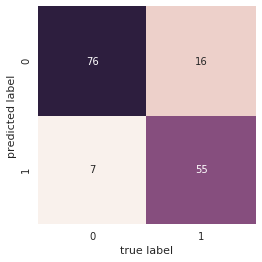

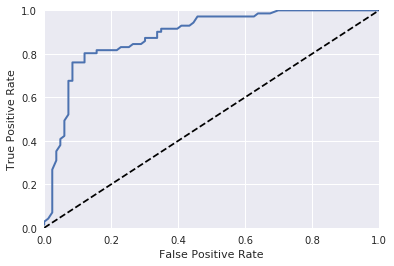

0.8840149329713219
Feature ranking:
1. feature 3 [MatemticaI120H] (0.177550)
2. feature 0 [LnguaPortuguesaeLiteraturaI90H] (0.163212)
3. feature 17 [conceito_R] (0.085406)
4. feature 5 [MatemticaI120H_freq] (0.051180)
5. feature 15 [conceito_I] (0.043580)
6. feature 2 [LnguaPortuguesaeLiteraturaI90H_freq] (0.032942)
7. feature 9 [idade] (0.024026)
8. feature 16 [conceito_O] (0.021692)
9. feature 1 [LnguaPortuguesaeLiteraturaI90H_dependencia] (0.017448)
10. feature 13 [qtd_pessoas_domicilio] (0.016049)
11. feature 11 [qnt_pc] (0.015576)
12. feature 4 [MatemticaI120H_dependencia] (0.015024)
13. feature 12 [qnt_salarios] (0.013691)
14. feature 14 [tempo_entre_conclusao_ingresso] (0.011275)
15. feature 19 [conceito_freq_R] (0.009589)
16. feature 129 [sigla_CNAT] (0.008451)
17. feature 6 [acompanhamento] (0.008444)
18. feature 7 [aluno_exclusivo_rede_publica] (0.007690)
19. feature 123 [pessoa_fisica__sexo_M] (0.007135)
20. feature 42 [descricao_historico_Técnico de Nível Médio em Eletrotéc

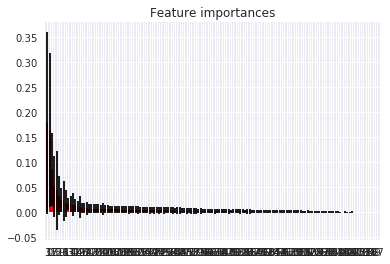

In [20]:
#seleciona o melhor modelo
model_forest_min = make_RF(Xtrain, ytrain)
ypred_forest = model_forest_min.predict(Xtest)

#avaliacao do modelo
evaluating(model_forest_min, ytest, ypred_forest, Xtest)

feature_ranking(Xtest, model_forest_min)

# Modelo 05: comparandos várias ML

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ubuntu/ana

SGD: 0.942362 (0.011911)
Valor de falso positivo:0.6385542168674698
0.963773069036227
0.9737569060773481
0.963773069036227
0.9737569060773481
0.9687392648574373
Precisao


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_ite

[0.05537459 0.80944625 0.94444444 0.9248366  0.95261438 0.94607843
 0.94444444 0.94934641 0.94281046 0.94934641]
0.8418742415532989


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


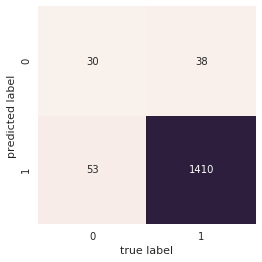

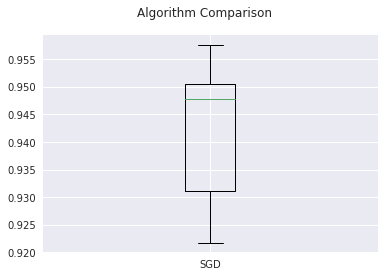

In [73]:
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.linear_model import SGDClassifier

models = []
#models.append(('LR', LogisticRegression()))
#models.append(('LDA', LinearDiscriminantAnalysis()))
#models.append(('KNN', KNeighborsClassifier()))
#models.append(('CART', DecisionTreeClassifier()))
#models.append(('NB', GaussianNB()))
#models.append(('SVM', SVC()))

models.append(('SGD', SGDClassifier(random_state=42)))
#{1:.9, 2:.5, 3:.01}

#models.append(('RF', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
#            max_depth=None, max_features='auto', max_leaf_nodes=None,
#            min_impurity_decrease=0.0, min_impurity_split=None,
#            min_samples_leaf=1, min_samples_split=2,
#            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
#            oob_score=False, random_state=None, verbose=0,
#            warm_start=False) ))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=0)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
    model.fit(Xtrain, ytrain)
    ypred = model.predict(Xtest)
    evaluating_2(model, ytest, ypred, X, y, Xtest)
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Comparando os modelos

In [ ]:
modelos_fp = [0.6330935251798561, 0.7266187050359713, 0.6385542168674698, 0.6385542168674698]